## Predict a tag for stack overflow question

In [1]:
!pip install -q -U tensorflow-text

In [2]:
import collections
import pathlib
import re
import string

import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras import utils
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

import tensorflow_datasets as tfds
import tensorflow_text as tf_text

In [3]:
data_url = 'https://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz'
dataset = utils.get_file(
    'stack_overflow_16k.tar.gz',
    data_url,
    untar=True,
    cache_dir='stack_overflow',
    cache_subdir='')
dataset_dir = pathlib.Path(dataset).parent

In [4]:
list(dataset_dir.iterdir())

[PosixPath('/tmp/.keras/stack_overflow_16k.tar.gz.tar.gz'),
 PosixPath('/tmp/.keras/README.md'),
 PosixPath('/tmp/.keras/test'),
 PosixPath('/tmp/.keras/train')]

In [5]:
train_dir = dataset_dir/'train'
list(train_dir.iterdir())

[PosixPath('/tmp/.keras/train/java'),
 PosixPath('/tmp/.keras/train/csharp'),
 PosixPath('/tmp/.keras/train/javascript'),
 PosixPath('/tmp/.keras/train/python')]

In [6]:
sample_file = train_dir/'python/1755.txt'
with open(sample_file) as f:
  print(f.read())

why does this blank program print true x=true.def stupid():.    x=false.stupid().print x



In [7]:
batch_size = 32
seed = 42

raw_train_ds = preprocessing.text_dataset_from_directory(
    train_dir,
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

Found 8000 files belonging to 4 classes.
Using 6400 files for training.


In [51]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(2):
    print("Question: ", text_batch.numpy()[i])
    print("Label:", label_batch.numpy()[i])

Question:  b'"language change with keydown event on all form i develop an application that can change language between english and hungarian. this software work with .resx files and when the user presses f2 the labels, buttons, and other controls their text properties will be changed from the .resx file. ..it\'s ok, but when i have more than one form open, naturally the keydown event changes those controls that are in the focused form. so my question is: how can i capture the f2 keystroke in all opened forms?"\n'
Label: 0
Question:  b'bubble sort without using temporary variable i want to sort both 1 dimensional and 2 dimensional array without using temp variable in blank..how to do it can anyone suggest\n'
Label: 1


In [9]:
for i, label in enumerate(raw_train_ds.class_names):
  print("Label", i, "corresponds to", label)

Label 0 corresponds to csharp
Label 1 corresponds to java
Label 2 corresponds to javascript
Label 3 corresponds to python


In [10]:
raw_val_ds = preprocessing.text_dataset_from_directory(
    train_dir,
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

Found 8000 files belonging to 4 classes.
Using 1600 files for validation.


In [11]:
test_dir = dataset_dir/'test'
raw_test_ds = preprocessing.text_dataset_from_directory(
    test_dir, batch_size=batch_size)

Found 8000 files belonging to 4 classes.


In [12]:
VOCAB_SIZE = 10000

binary_vectorize_layer = TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode='binary')

In [13]:
MAX_SEQUENCE_LENGTH = 250

int_vectorize_layer = TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode='int',
    output_sequence_length=MAX_SEQUENCE_LENGTH)

In [14]:
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda text, labels: text)
binary_vectorize_layer.adapt(train_text)
int_vectorize_layer.adapt(train_text)

In [15]:
def binary_vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return binary_vectorize_layer(text), label

def int_vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return int_vectorize_layer(text), label

In [16]:
# Retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_question, first_label = text_batch[0], label_batch[0]
print("Question", first_question)
print("Label", first_label)

Question tf.Tensor(b'"function expected error in blank for dynamically created check box when it is clicked i want to grab the attribute value.it is working in ie 8,9,10 but not working in ie 11,chrome shows function expected error..&lt;input type=checkbox checked=\'checked\' id=\'symptomfailurecodeid\' tabindex=\'54\' style=\'cursor:pointer;\' onclick=chkclickevt(this);  failurecodeid=""1"" &gt;...function chkclickevt(obj) { .    alert(obj.attributes(""failurecodeid""));.}"\n', shape=(), dtype=string)
Label tf.Tensor(2, shape=(), dtype=int32)


In [17]:
print("'binary' vectorized question:", 
      binary_vectorize_text(first_question, first_label)[0])

'binary' vectorized question: tf.Tensor([[1. 1. 1. ... 0. 0. 0.]], shape=(1, 10000), dtype=float32)


In [18]:
print("'int' vectorized question:",
      int_vectorize_text(first_question, first_label)[0])

'int' vectorized question: tf.Tensor(
[[  38  450   65    7   16   12  892  265  186  451   44   11    6  685
     3   46    4 2062    2  485    1    6  158    7  479    1   26   20
   158    7  479    1  502   38  450    1 1767 1763    1    1    1    1
     1    1    1    1    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0

In [19]:
print("1289 ---> ", int_vectorize_layer.get_vocabulary()[1289])
print("313 ---> ", int_vectorize_layer.get_vocabulary()[313])
print("Vocabulary size: {}".format(len(int_vectorize_layer.get_vocabulary())))

1289 --->  roman
313 --->  source
Vocabulary size: 10000


In [20]:
binary_train_ds = raw_train_ds.map(binary_vectorize_text)
binary_val_ds = raw_val_ds.map(binary_vectorize_text)
binary_test_ds = raw_test_ds.map(binary_vectorize_text)

int_train_ds = raw_train_ds.map(int_vectorize_text)
int_val_ds = raw_val_ds.map(int_vectorize_text)
int_test_ds = raw_test_ds.map(int_vectorize_text)

In [21]:
AUTOTUNE = tf.data.AUTOTUNE

def configure_dataset(dataset):
  return dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [22]:
binary_train_ds = configure_dataset(binary_train_ds)
binary_val_ds = configure_dataset(binary_val_ds)
binary_test_ds = configure_dataset(binary_test_ds)

int_train_ds = configure_dataset(int_train_ds)
int_val_ds = configure_dataset(int_val_ds)
int_test_ds = configure_dataset(int_test_ds)

## Train the model

In [23]:
# train a simple bow linear model

In [24]:
binary_model = tf.keras.Sequential([layers.Dense(4)])
binary_model.compile(
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=['accuracy'])
history = binary_model.fit(
    binary_train_ds, validation_data=binary_val_ds, epochs=10)

Epoch 1/10
200/200 [==============================] - 4s 20ms/step - loss: 1.2382 - accuracy: 0.5338 - val_loss: 0.9098 - val_accuracy: 0.7906
Epoch 2/10
200/200 [==============================] - 1s 4ms/step - loss: 0.8161 - accuracy: 0.8261 - val_loss: 0.7472 - val_accuracy: 0.8106
Epoch 3/10
200/200 [==============================] - 1s 4ms/step - loss: 0.6495 - accuracy: 0.8594 - val_loss: 0.6623 - val_accuracy: 0.8156
Epoch 4/10
200/200 [==============================] - 1s 4ms/step - loss: 0.5505 - accuracy: 0.8835 - val_loss: 0.6094 - val_accuracy: 0.8231
Epoch 5/10
200/200 [==============================] - 1s 4ms/step - loss: 0.4817 - accuracy: 0.8998 - val_loss: 0.5730 - val_accuracy: 0.8338
Epoch 6/10
200/200 [==============================] - 1s 4ms/step - loss: 0.4298 - accuracy: 0.9141 - val_loss: 0.5465 - val_accuracy: 0.8400
Epoch 7/10
200/200 [==============================] - 1s 4ms/step - loss: 0.3886 - accuracy: 0.9259 - val_loss: 0.5266 - val_accuracy: 0.8413
Epoch

In [25]:
# build a 1D ConVnet
def create_model(vocab_size, num_labels):
  model = tf.keras.Sequential([
      layers.Embedding(vocab_size, 64, mask_zero=True),
      layers.Conv1D(64, 5, padding="valid", activation="relu", strides=2),
      layers.GlobalMaxPooling1D(),
      layers.Dense(num_labels)
  ])
  return model



In [26]:
# vocab_size is VOCAB_SIZE + 1 since 0 is used additionally for padding.
int_model = create_model(vocab_size=VOCAB_SIZE + 1, num_labels=4)
int_model.compile(
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=['accuracy'])
history = int_model.fit(int_train_ds, validation_data=int_val_ds, epochs=5)

Epoch 1/5
200/200 [==============================] - 9s 40ms/step - loss: 1.2838 - accuracy: 0.3963 - val_loss: 0.7544 - val_accuracy: 0.7000
Epoch 2/5
200/200 [==============================] - 6s 29ms/step - loss: 0.6979 - accuracy: 0.7172 - val_loss: 0.5518 - val_accuracy: 0.7887
Epoch 3/5
200/200 [==============================] - 6s 28ms/step - loss: 0.4327 - accuracy: 0.8498 - val_loss: 0.4917 - val_accuracy: 0.8163
Epoch 4/5
200/200 [==============================] - 6s 32ms/step - loss: 0.2564 - accuracy: 0.9329 - val_loss: 0.4819 - val_accuracy: 0.8194
Epoch 5/5
200/200 [==============================] - 6s 29ms/step - loss: 0.1371 - accuracy: 0.9732 - val_loss: 0.4977 - val_accuracy: 0.8225


## Models architecture

In [27]:
binary_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 4)                 40004     
Total params: 40,004
Trainable params: 40,004
Non-trainable params: 0
_________________________________________________________________


In [28]:
int_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          640064    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 64)          20544     
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 260       
Total params: 660,868
Trainable params: 660,868
Non-trainable params: 0
_________________________________________________________________


## evaluate the models on the test data

In [29]:
binary_loss, binary_accuracy = binary_model.evaluate(binary_test_ds)
int_loss, int_accuracy = int_model.evaluate(int_test_ds)

print("Binary model accuracy: {:2.2%}".format(binary_accuracy))
print("Int model accuracy: {:2.2%}".format(int_accuracy))

250/250 [==============================] - 4s 16ms/step - loss: 0.5355 - accuracy: 0.8044
Binary model accuracy: 81.58%
Int model accuracy: 80.44%


## export the model

In [30]:
export_model = tf.keras.Sequential(
    [binary_vectorize_layer, binary_model,
     layers.Activation('sigmoid')])

export_model.compile(
    loss=losses.SparseCategoricalCrossentropy(from_logits=False),
    optimizer='adam',
    metrics=['accuracy'])

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print("Accuracy: {:2.2%}".format(binary_accuracy))

250/250 [==============================] - 4s 14ms/step - loss: 0.5110 - accuracy: 0.8198
Accuracy: 81.58%


In [31]:
# the model now can take raw strings as input
def get_string_labels(predicted_scores_batch):
  predicted_int_labels = tf.argmax(predicted_scores_batch, axis=1)
  predicted_labels = tf.gather(raw_train_ds.class_names, predicted_int_labels)
  return predicted_labels

In [32]:
# run on new data
inputs = [
    "how do I extract keys from a dict into a list?",  # python
    "debug public static void main(string[] args) {...}",  # java
]
predicted_scores = export_model.predict(inputs)
predicted_labels = get_string_labels(predicted_scores)
for input, label in zip(inputs, predicted_labels):
  print("question: ", input)
  print("prediction: ", label.numpy())

question:  how do I extract keys from a dict into a list?
prediction:  b'python'
question:  debug public static void main(string[] args) {...}
prediction:  b'java'


## evaluate the performance

In [33]:
prediction_bin = binary_model.predict_classes(binary_test_ds)

prediction_int = int_model.predict_classes(int_test_ds)


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [34]:
# extract only the labels
import numpy as np

numpy_labels_bin = np.concatenate([y for x, y in binary_test_ds], axis=0)

numpy_labels_int = np.concatenate([y for x, y in int_test_ds], axis=0)

In [35]:
print(len(numpy_labels_bin), len(numpy_labels_bin))
numpy_labels_bin

8000 8000


array([1, 3, 0, ..., 0, 1, 2], dtype=int32)

In [36]:
con_mat_bin = tf.math.confusion_matrix(labels=numpy_labels_bin, predictions=prediction_bin).numpy()
# normalize
con_mat_bin = tf.cast(con_mat_bin, dtype=tf.float32)
con_mat_bin = con_mat_bin / tf.math.reduce_sum(con_mat_bin, axis=1)[:, np.newaxis]
con_mat_bin

<tf.Tensor: shape=(4, 4), dtype=float32, numpy=
array([[0.7495, 0.1225, 0.0615, 0.0665],
       [0.121 , 0.754 , 0.036 , 0.089 ],
       [0.0505, 0.0265, 0.863 , 0.06  ],
       [0.038 , 0.023 , 0.0425, 0.8965]], dtype=float32)>

In [37]:
con_mat_int = tf.math.confusion_matrix(labels=numpy_labels_int, predictions=prediction_int).numpy()
# Normalize
con_mat_int = tf.cast(con_mat_int, dtype=tf.float32)
con_mat_int = con_mat_int / tf.math.reduce_sum(con_mat_int, axis=1)[:, np.newaxis]
con_mat_int

<tf.Tensor: shape=(4, 4), dtype=float32, numpy=
array([[0.7275, 0.134 , 0.0685, 0.07  ],
       [0.1145, 0.769 , 0.04  , 0.0765],
       [0.0575, 0.0295, 0.8485, 0.0645],
       [0.034 , 0.039 , 0.0545, 0.8725]], dtype=float32)>

confusion matrix for int mode


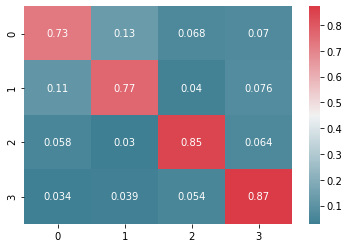

In [38]:
import seaborn as sns

cmap = sns.diverging_palette(220, 10, as_cmap=True)
print("confusion matrix for int mode")
sns.heatmap(con_mat_int, cmap=cmap, annot=True)

confusion matrix for binary mode


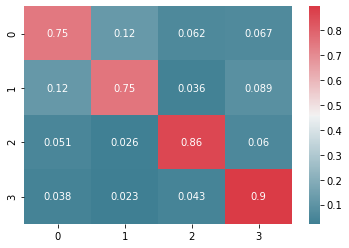

In [39]:
print("confusion matrix for binary mode")
sns.heatmap(con_mat_bin, cmap=cmap, annot=True)

## RNN

In [40]:
len(binary_vectorize_layer.get_vocabulary())

10000

In [41]:
train_data_int = np.concatenate([x for x, y in int_train_ds], axis=0)
train_labels_int = np.concatenate([y for x, y in int_train_ds], axis=0)

In [42]:
def create_model_rnn(vocab_size, num_labels):
  model_rnn = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(num_labels)
])
  return model_rnn

In [47]:
int_model_rnn = create_model_rnn(vocab_size=VOCAB_SIZE + 1, num_labels=4)
int_model_rnn.compile(
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=['accuracy'])
history_rnn = int_model_rnn.fit(int_train_ds, validation_data=int_val_ds, epochs=10)

Epoch 1/10
200/200 [==============================] - 82s 375ms/step - loss: 1.2990 - accuracy: 0.3483 - val_loss: 0.8228 - val_accuracy: 0.6125
Epoch 2/10
200/200 [==============================] - 72s 362ms/step - loss: 0.8119 - accuracy: 0.6602 - val_loss: 0.6893 - val_accuracy: 0.7194
Epoch 3/10
200/200 [==============================] - 72s 359ms/step - loss: 0.5113 - accuracy: 0.8105 - val_loss: 0.6340 - val_accuracy: 0.7613
Epoch 4/10
200/200 [==============================] - 72s 360ms/step - loss: 0.3097 - accuracy: 0.8920 - val_loss: 0.7621 - val_accuracy: 0.7575
Epoch 5/10
200/200 [==============================] - 73s 364ms/step - loss: 0.2244 - accuracy: 0.9270 - val_loss: 0.7503 - val_accuracy: 0.7606
Epoch 6/10
200/200 [==============================] - 71s 355ms/step - loss: 0.1556 - accuracy: 0.9529 - val_loss: 0.8231 - val_accuracy: 0.7337
Epoch 7/10
200/200 [==============================] - 71s 353ms/step - loss: 0.1119 - accuracy: 0.9644 - val_loss: 0.8738 - val_ac

In [48]:
prediction_int_rnn = int_model_rnn.predict_classes(int_test_ds)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [49]:
con_mat_int_rnn = tf.math.confusion_matrix(labels=numpy_labels_int, predictions=prediction_int_rnn).numpy()
# Normalize
con_mat_int_rnn = tf.cast(con_mat_int_rnn, dtype=tf.float32)
con_mat_int_rnn = con_mat_int_rnn / tf.math.reduce_sum(con_mat_int_rnn, axis=1)[:, np.newaxis]
con_mat_int_rnn

<tf.Tensor: shape=(4, 4), dtype=float32, numpy=
array([[0.663 , 0.1665, 0.0815, 0.089 ],
       [0.1515, 0.7305, 0.045 , 0.073 ],
       [0.083 , 0.047 , 0.795 , 0.075 ],
       [0.0625, 0.0675, 0.054 , 0.816 ]], dtype=float32)>

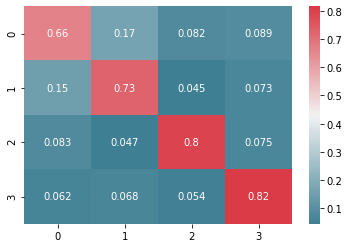

In [50]:
sns.heatmap(con_mat_int_rnn, cmap=cmap, annot=True)